# Bachelor Thesis: Predicting flight delays
#### Author: Tygo Francissen, s1049742, Radboud University
This thesis aims to predict flight delays in the United States and Brazil by using a broad scale of machine learning algorithms and transfer learning.

#### 1.1 Gathering the data
The data sets are gathered from the [Bureau of Transportation Statistics](https://www.transtats.bts.gov) and the [VRA](https://sas.anac.gov.br/sas/bav/view/frmConsultaVRA). Firstly, we store the data, which ranges from January 1st 2022 until January 31st 2022 for both data sets.

In [161]:
# All imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from deep_translator import GoogleTranslator
from pandas.api.types import is_numeric_dtype

In [3]:
# Store the data sets for January 2022
data_brazil = pd.read_excel('../Data/VRA_20230228124648.xlsx')
data_usa = pd.read_csv('../Data/T_ONTIME_REPORTING.csv')

#### 1.2 Preprocessing the Brazilian data

Let's have a look at the Brazilian flight data set first.

In [4]:
display(data_brazil)

,Sigla ICAO Empresa Aérea,Empresa Aérea,Número Voo,Código DI,Código Tipo Linha,Modelo Equipamento,Número de Assentos,Sigla ICAO Aeroporto Origem,Descrição Aeroporto Origem,Partida Prevista,Partida Real,Sigla ICAO Aeroporto Destino,Descrição Aeroporto Destino,Chegada Prevista,Chegada Real,Situação Voo,Justificativa,Referência,Situação Partida,Situação Chegada
0,AAL,"AMERICAN AIRLINES, INC.",904,0,I,B788,295,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,2022-01-01 00:05:00,NaT,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 08:50:00,NaT,CANCELADO,NaN,2022-01-01,NaN,NaN
1,AAL,"AMERICAN AIRLINES, INC.",905,0,I,B788,295,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 22:00:00,NaT,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,2022-01-02 06:20:00,NaT,CANCELADO,NaN,2022-01-01,NaN,NaN
2,AAL,"AMERICAN AIRLINES, INC.",906,0,I,B77W,318,SBGR,GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...,2022-01-01 00:05:00,NaT,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 08:40:00,NaT,CANCELADO,NaN,2022-01-01,NaN,NaN
3,AAL,"AMERICAN AIRLINES, INC.",929,0,I,B77W,318,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 22:00:00,NaT,SBGR,GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...,2022-01-02 06:20:00,NaT,CANCELADO,NaN,2022-01-01,NaN,NaN
4,AAL,"AMERICAN AIRLINES, INC.",930,0,I,B788,295,SBGR,GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...,2022-01-01 22:30:00,NaT,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-02 06:55:00,NaT,CANCELADO,NaN,2022-01-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70663,UPS,UPS - UNITED PARCEL SERVICE CO.,444,0,X,B763,0,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-30 08:10:00,2022-01-30 09:17:00,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,2022-01-30 16:10:00,2022-01-30 17:18:00,REALIZADO,NaN,2022-01-30,Atraso 60-120,Atraso 60-120
70664,UPS,UPS - UNITED PARCEL SERVICE CO.,445,0,X,B763,0,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,2022-01-30 17:40:00,2022-01-30 18:26:00,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-31 01:30:00,2022-01-31 02:30:00,REALIZADO,NaN,2022-01-30,Atraso 30-60,Atraso 30-60
70665,UPS,UPS - UNITED PARCEL SERVICE CO.,417,0,X,B763,0,SKBO,EL DORADO INTERNATIONAL AIRPORT - BOGOTÁ - COL...,2022-02-01 07:50:00,2022-02-01 07:24:00,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-02-01 11:25:00,2022-02-01 11:08:00,REALIZADO,NaN,2022-01-31,Antecipado,Antecipado
70666,UPS,UPS - UNITED PARCEL SERVICE CO.,417,0,X,B763,0,SAEZ,MINISTRO PISTARINI INTERNATIONAL AIRPORT (EZEI...,2022-01-31 20:10:00,2022-01-31 19:34:00,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,2022-01-31 22:40:00,2022-01-31 22:04:00,REALIZADO,NaN,2022-01-31,Antecipado,Antecipado


The Brazilian data set is written in Brazilian language, while the author is unable to read this language. Therefore, we translate the column names of the Brazilian data set into English text. To increase readability of the data, two lookup dictionaries for the airline and airport ICAO code are created (and translated).

In [6]:
# Translate the column names of the Brazilian data set
translator = GoogleTranslator(source='auto', target='en')
for i, _ in enumerate(data_brazil.columns.values):
    data_brazil.rename(columns={data_brazil.columns.values[i]:translator.translate(data_brazil.columns.values[i])}, inplace=True)
    
# Create dictionary to look up full name of airline ICAO code
values = [translator.translate(name) for name in data_brazil["airline"].unique()]
airline_code_dict = dict(zip(data_brazil["Acronym ICAO Airline"].unique(), values))

# Create dictionary to look up full name of airport ICAO code
keys = pd.unique(np.concatenate((data_brazil["Acronym ICAO Airport Origin"].unique(),data_brazil["Acronym ICAO Destiny Airport"].unique())))
airports = pd.unique(np.concatenate((data_brazil["Description Origin Airport"].unique(),data_brazil["Destination Airport Description"].unique())))
values = [translator.translate(name) for name in airports]
airport_code_dict = dict(zip(keys, values))

Since some columns still contain Brazilian words, the remaining words are translated to English.

In [7]:
# Translate remaining Brazilian words in data set
for word in data_brazil["Flight Status"].unique():
    data_brazil["Flight Status"] = data_brazil["Flight Status"].replace(word, translator.translate(word))

for word in data_brazil["Starting Status"].unique():
    if not type(word)==float:
        data_brazil["Starting Status"] = data_brazil["Starting Status"].replace(word, translator.translate(word))

for word in data_brazil["Arrival Status"].unique():
    if not type(word)==float:
        data_brazil["Arrival Status"] = data_brazil["Arrival Status"].replace(word, translator.translate(word))

Now that all text has been properly translated, we can have a look at the data again.

In [8]:
display(data_brazil)

,Acronym ICAO Airline,airline,Flight Number,Code DI,Line Type Code,Model Equipment,Number of Seats,Acronym ICAO Airport Origin,Description Origin Airport,Scheduled departure,actual match,Acronym ICAO Destiny Airport,Destination Airport Description,Expected Arrival,actual arrival,Flight Status,Justification,Reference,Starting Status,Arrival Status
0,AAL,"AMERICAN AIRLINES, INC.",904,0,I,B788,295,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,2022-01-01 00:05:00,NaT,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 08:50:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
1,AAL,"AMERICAN AIRLINES, INC.",905,0,I,B788,295,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 22:00:00,NaT,SBGL,AEROPORTO INTERNACIONAL DO RIO DE JANEIRO (GAL...,2022-01-02 06:20:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
2,AAL,"AMERICAN AIRLINES, INC.",906,0,I,B77W,318,SBGR,GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...,2022-01-01 00:05:00,NaT,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 08:40:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
3,AAL,"AMERICAN AIRLINES, INC.",929,0,I,B77W,318,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-01 22:00:00,NaT,SBGR,GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...,2022-01-02 06:20:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
4,AAL,"AMERICAN AIRLINES, INC.",930,0,I,B788,295,SBGR,GUARULHOS - GOVERNADOR ANDRÉ FRANCO MONTORO - ...,2022-01-01 22:30:00,NaT,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-02 06:55:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70663,UPS,UPS - UNITED PARCEL SERVICE CO.,444,0,X,B763,0,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-30 08:10:00,2022-01-30 09:17:00,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,2022-01-30 16:10:00,2022-01-30 17:18:00,ACCOMPLISHED,NaN,2022-01-30,Delay 60-120,Delay 60-120
70664,UPS,UPS - UNITED PARCEL SERVICE CO.,445,0,X,B763,0,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,2022-01-30 17:40:00,2022-01-30 18:26:00,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-01-31 01:30:00,2022-01-31 02:30:00,ACCOMPLISHED,NaN,2022-01-30,Delay 30-60,Delay 30-60
70665,UPS,UPS - UNITED PARCEL SERVICE CO.,417,0,X,B763,0,SKBO,EL DORADO INTERNATIONAL AIRPORT - BOGOTÁ - COL...,2022-02-01 07:50:00,2022-02-01 07:24:00,KMIA,"MIAMI INTERNATIONAL AIRPORT - MIAMI, FLORIDA -...",2022-02-01 11:25:00,2022-02-01 11:08:00,ACCOMPLISHED,NaN,2022-01-31,anticipated,anticipated
70666,UPS,UPS - UNITED PARCEL SERVICE CO.,417,0,X,B763,0,SAEZ,MINISTRO PISTARINI INTERNATIONAL AIRPORT (EZEI...,2022-01-31 20:10:00,2022-01-31 19:34:00,SBKP,VIRACOPOS - CAMPINAS - SP - BRASIL,2022-01-31 22:40:00,2022-01-31 22:04:00,ACCOMPLISHED,NaN,2022-01-31,anticipated,anticipated


Since we created lookup dictionaries for the airline and airport ICAO code, the columns 'airline', 'Description Origin Airport', and 'Destination Airport Description' can be removed. Also, the data is ordered on their departure date, and the last entry seems to fall outside the month January, which is the reason why it got removed.

In [155]:
# Remove redundant columns and wrong date entry
data_brazil2 = data_brazil.drop(columns=['airline', 'Description Origin Airport', 'Destination Airport Description'])
data_brazil2 = data_brazil2.drop(70667)
display(data_brazil2)

,Acronym ICAO Airline,Flight Number,Code DI,Line Type Code,Model Equipment,Number of Seats,Acronym ICAO Airport Origin,Scheduled departure,actual match,Acronym ICAO Destiny Airport,Expected Arrival,actual arrival,Flight Status,Justification,Reference,Starting Status,Arrival Status
0,AAL,904,0,I,B788,295,SBGL,2022-01-01 00:05:00,NaT,KMIA,2022-01-01 08:50:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
1,AAL,905,0,I,B788,295,KMIA,2022-01-01 22:00:00,NaT,SBGL,2022-01-02 06:20:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
2,AAL,906,0,I,B77W,318,SBGR,2022-01-01 00:05:00,NaT,KMIA,2022-01-01 08:40:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
3,AAL,929,0,I,B77W,318,KMIA,2022-01-01 22:00:00,NaT,SBGR,2022-01-02 06:20:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
4,AAL,930,0,I,B788,295,SBGR,2022-01-01 22:30:00,NaT,KMIA,2022-01-02 06:55:00,NaT,CANCELED,NaN,2022-01-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70662,UPS,416,0,X,B763,0,SCEL,2022-01-31 00:30:00,2022-01-31 00:33:00,SAEZ,2022-01-31 02:15:00,2022-01-31 02:17:00,ACCOMPLISHED,NaN,2022-01-30,One-off,One-off
70663,UPS,444,0,X,B763,0,KMIA,2022-01-30 08:10:00,2022-01-30 09:17:00,SBKP,2022-01-30 16:10:00,2022-01-30 17:18:00,ACCOMPLISHED,NaN,2022-01-30,Delay 60-120,Delay 60-120
70664,UPS,445,0,X,B763,0,SBKP,2022-01-30 17:40:00,2022-01-30 18:26:00,KMIA,2022-01-31 01:30:00,2022-01-31 02:30:00,ACCOMPLISHED,NaN,2022-01-30,Delay 30-60,Delay 30-60
70665,UPS,417,0,X,B763,0,SKBO,2022-02-01 07:50:00,2022-02-01 07:24:00,KMIA,2022-02-01 11:25:00,2022-02-01 11:08:00,ACCOMPLISHED,NaN,2022-01-31,anticipated,anticipated


Now that the redundant columns have been removed, we can have a look at the values of the columns and its properties.

In [156]:
print(data_brazil2.count())

Acronym ICAO Airline            70667
Flight Number                   70667
Code DI                         70667
Line Type Code                  70667
Model Equipment                 70667
Number of Seats                 70667
Acronym ICAO Airport Origin     70667
Scheduled departure             70667
actual match                    66290
Acronym ICAO Destiny Airport    70667
Expected Arrival                70667
actual arrival                  66290
Flight Status                   70667
Justification                       0
Reference                       70667
Starting Status                 66290
Arrival Status                  66290
dtype: int64


The justification column has no record, thus it will be removed. We can make histograms to visualize the distributions of the data.

In [157]:
# Drop justification column as it has no entries
data_brazil2.drop(columns=['Justification'], inplace=True)

If we look at the flight status column, it can be seen that there are 3 possible options: canceled, uninformed and accomplished. Since we are only interested in flight delays, we will only look at flights that have been accomplished. That leaves this column with only one possible value, so the column can be removed as well.

In [163]:
# Drop entries of flights that are cancelled or uninformed
data_brazil3 = data_brazil2.drop(data_brazil2[(data_brazil2["Flight Status"] == "CANCELED") | (data_brazil2["Flight Status"] == "UNINFORMED")].index)

# Drop flight status column as it has no use anymore
data_brazil3.drop(columns=['Flight Status'], inplace=True)

To create our response variable, we are calculating the total delay of each flight. The total delay is calculated by adding the arrival delay to the departure delay. If the total delay is more than 15 minutes, the flight is considered delayed.

In [164]:
# Change starting status column to represent whether the departure delay is more than 15 minutes
data_brazil3.loc[(data_brazil3["actual match"]-data_brazil3["Scheduled departure"]) <= datetime.timedelta(minutes=15), "Starting Status"] = 0
data_brazil3.loc[(data_brazil3["actual match"]-data_brazil3["Scheduled departure"]) > datetime.timedelta(minutes=15), "Starting Status"] = 1

# Change arrival status column to represent whether the arrival delay is more than 15 minutes
data_brazil3.loc[(data_brazil3["actual arrival"]-data_brazil3["Expected Arrival"]) <= datetime.timedelta(minutes=15), "Arrival Status"] = 0
data_brazil3.loc[(data_brazil3["actual arrival"]-data_brazil3["Expected Arrival"]) > datetime.timedelta(minutes=15), "Arrival Status"] = 1

# Create new column "Delayed" which represents whether the total delay of the flight is more than 15 minutes
data_brazil3.reset_index(drop=True, inplace=True)
data_brazil3.loc[(data_brazil3["actual match"]-data_brazil3["Scheduled departure"]) + (data_brazil3["actual arrival"]-data_brazil3["Expected Arrival"]) <= datetime.timedelta(minutes=15), "Delayed"] = 0
data_brazil3.loc[(data_brazil3["actual match"]-data_brazil3["Scheduled departure"]) + (data_brazil3["actual arrival"]-data_brazil3["Expected Arrival"]) > datetime.timedelta(minutes=15), "Delayed"] = 1
data_brazil3["Delayed"] = data_brazil3["Delayed"].astype(int)

display(data_brazil3)

,Acronym ICAO Airline,Flight Number,Code DI,Line Type Code,Model Equipment,Number of Seats,Acronym ICAO Airport Origin,Scheduled departure,actual match,Acronym ICAO Destiny Airport,Expected Arrival,actual arrival,Reference,Starting Status,Arrival Status,Delayed
0,ACA,90,0,X,B773,450,CYYZ,2022-01-01 00:50:00,2022-01-01 01:32:00,SBGR,2022-01-01 10:50:00,2022-01-01 10:51:00,2022-01-01,1,0,1
1,ACA,91,0,X,B773,450,SBGR,2022-01-01 20:45:00,2022-01-01 21:04:00,CYYZ,2022-01-02 06:45:00,2022-01-02 07:07:00,2022-01-01,1,1,1
2,ACA,97,0,X,B789,300,SAEZ,2022-01-01 16:45:00,2022-01-01 17:34:00,SBGR,2022-01-01 19:45:00,2022-01-01 20:13:00,2022-01-01,1,1,1
3,ACA,97,0,X,B789,300,SBGR,2022-01-01 22:00:00,2022-01-01 22:10:00,CYUL,2022-01-02 08:00:00,2022-01-02 08:24:00,2022-01-01,0,1,1
4,ACA,90,0,X,B773,450,CYYZ,2022-01-02 00:50:00,2022-01-02 04:59:00,SBGR,2022-01-02 10:50:00,2022-01-02 14:59:00,2022-01-02,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66285,UPS,416,0,X,B763,0,SCEL,2022-01-31 00:30:00,2022-01-31 00:33:00,SAEZ,2022-01-31 02:15:00,2022-01-31 02:17:00,2022-01-30,0,0,0
66286,UPS,444,0,X,B763,0,KMIA,2022-01-30 08:10:00,2022-01-30 09:17:00,SBKP,2022-01-30 16:10:00,2022-01-30 17:18:00,2022-01-30,1,1,1
66287,UPS,445,0,X,B763,0,SBKP,2022-01-30 17:40:00,2022-01-30 18:26:00,KMIA,2022-01-31 01:30:00,2022-01-31 02:30:00,2022-01-30,1,1,1
66288,UPS,417,0,X,B763,0,SKBO,2022-02-01 07:50:00,2022-02-01 07:24:00,KMIA,2022-02-01 11:25:00,2022-02-01 11:08:00,2022-01-31,0,0,0


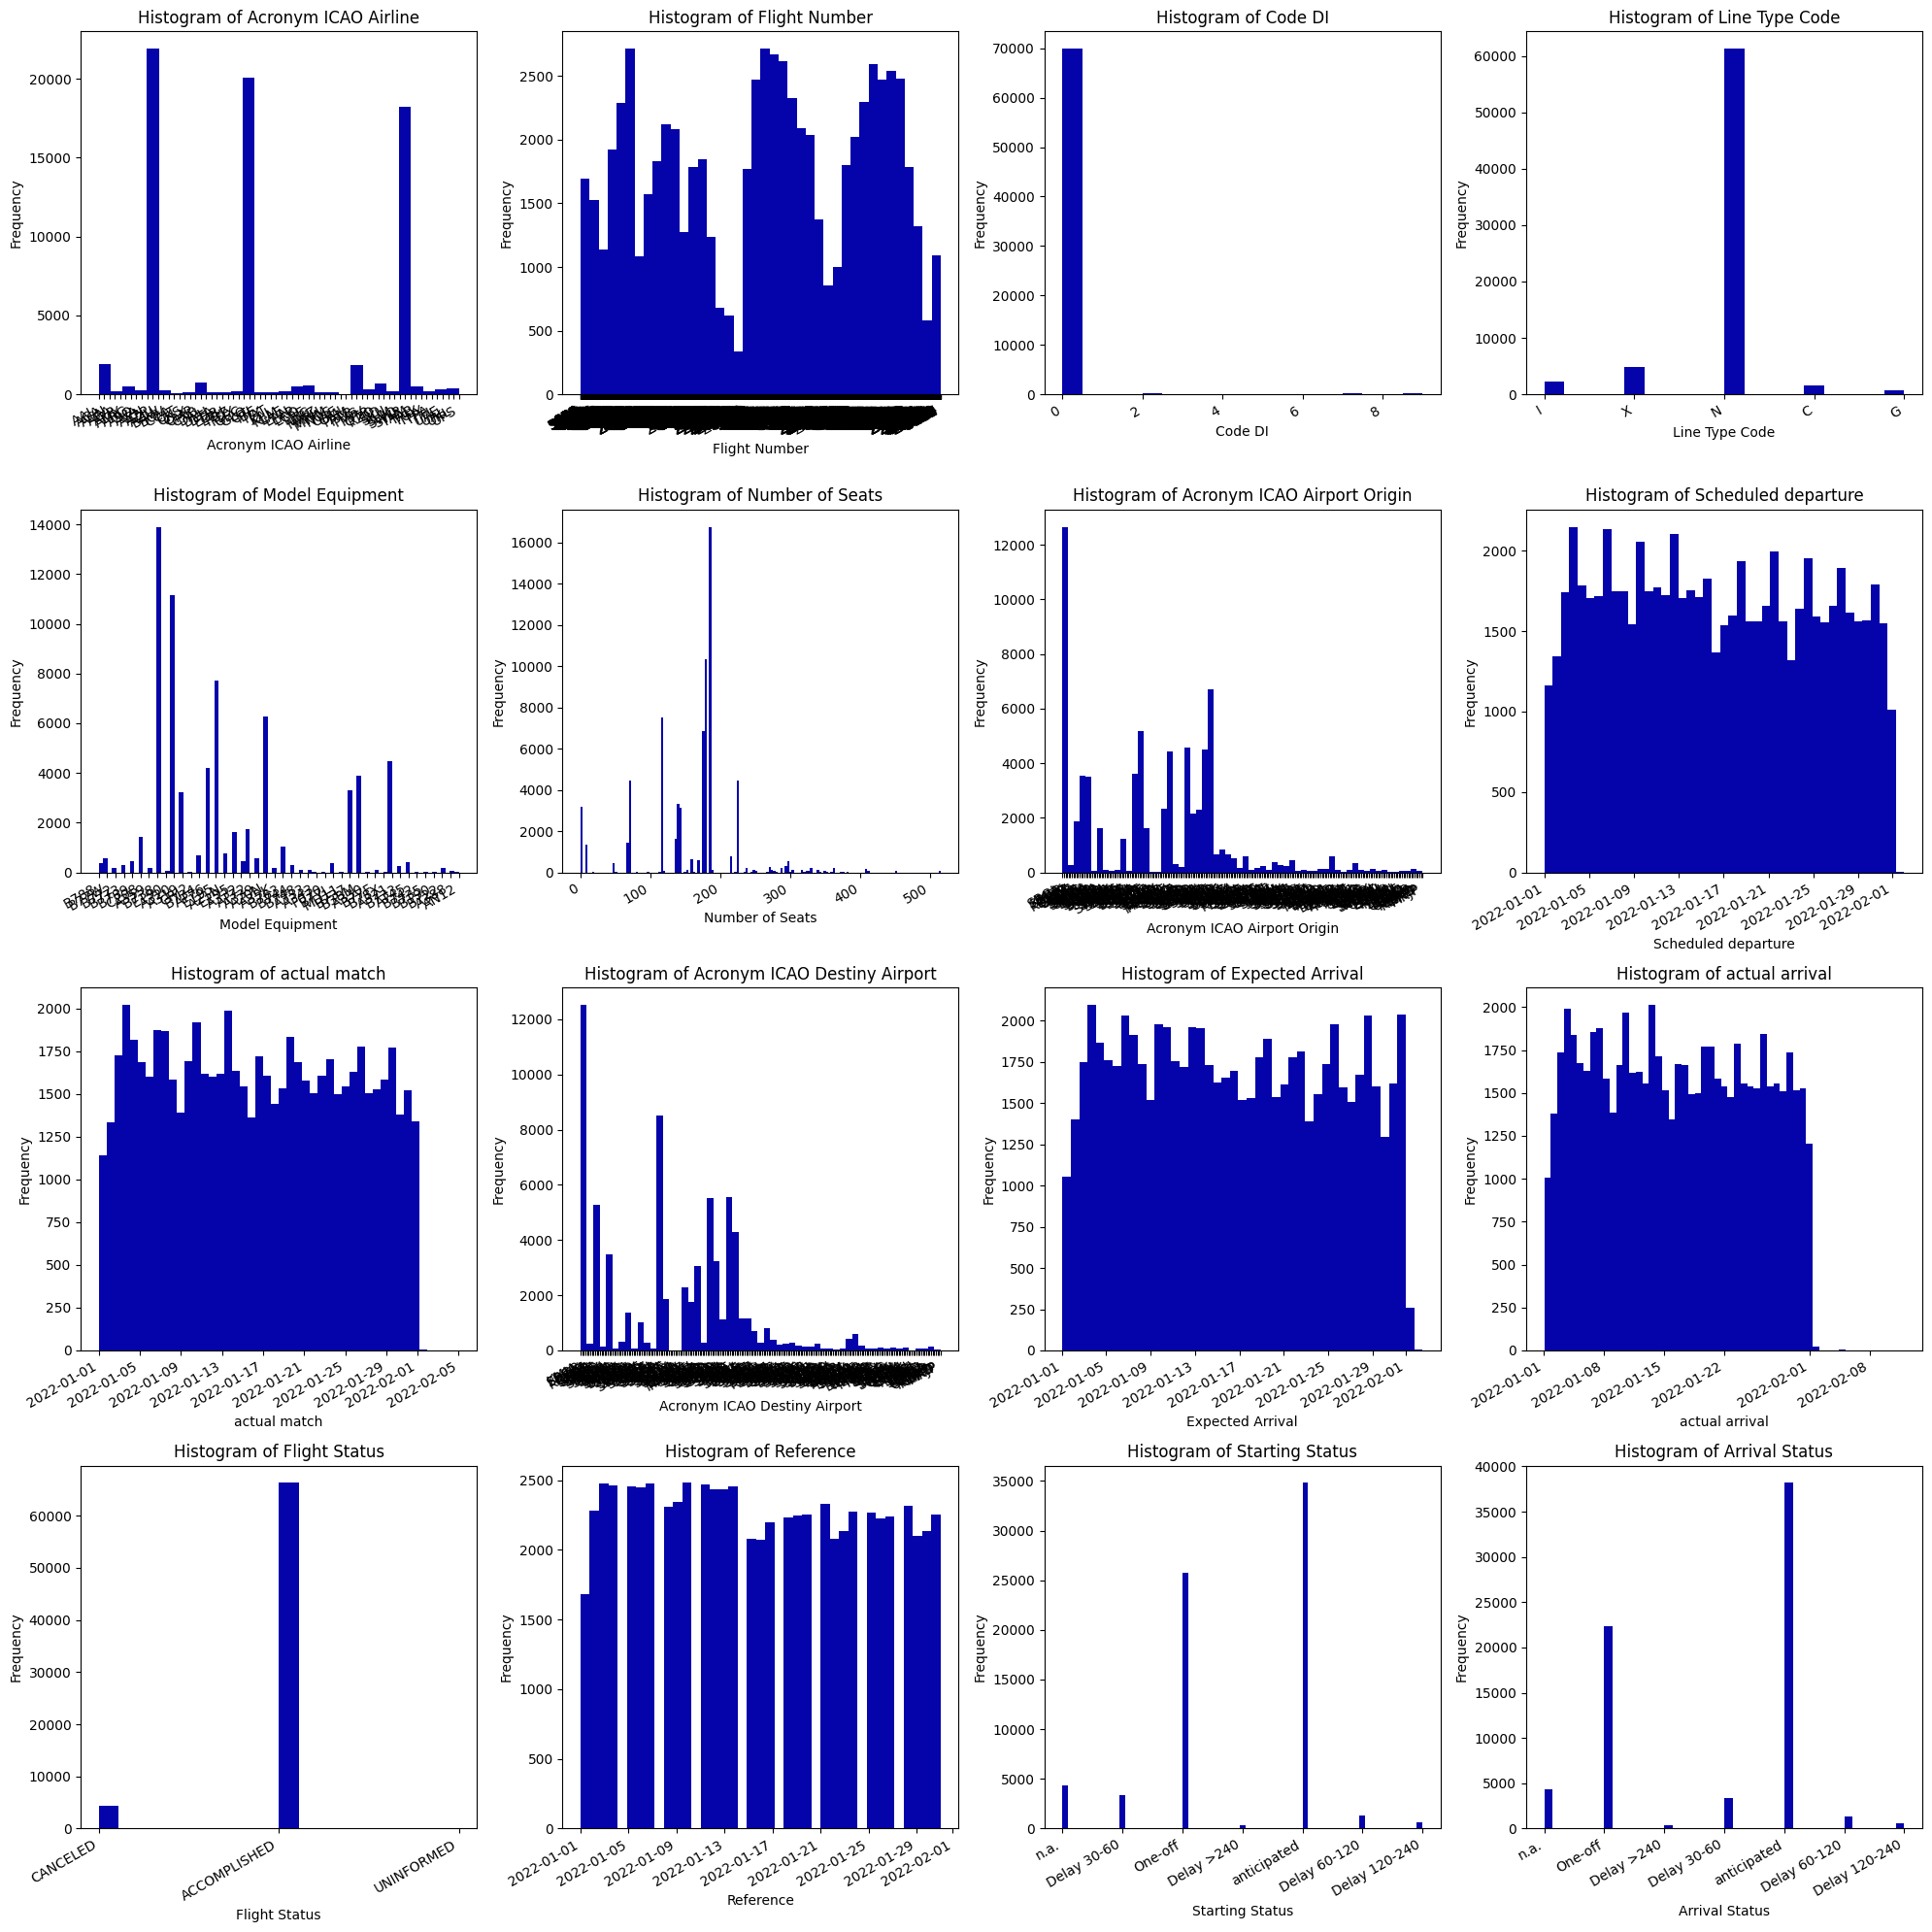

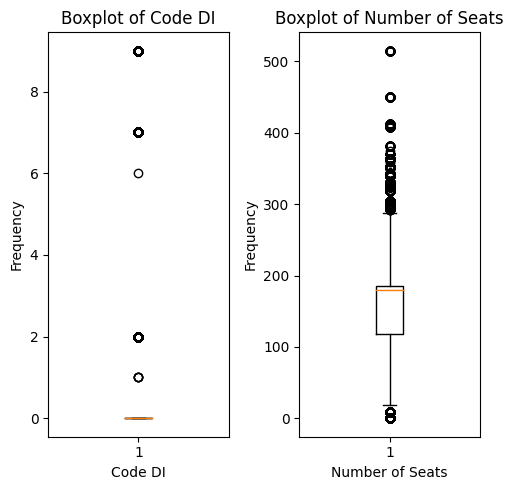

In [31]:
# Reform columns to correct datatype and replace NaN's with string
data_brazil2["Flight Number"] = data_brazil2["Flight Number"].astype(str)
data_brazil2["Starting Status"] = data_brazil2["Starting Status"].fillna('n.a.')
data_brazil2["Arrival Status"] = data_brazil2["Arrival Status"].fillna('n.a.')

# Plot histograms for each column
fig, axs = plt.subplots(4,4, figsize=(20,20))
x = 0; y = 0
for i, name in enumerate(data_brazil2.columns.values):
    if i % 4 == 0 and i != 0:
        y = 0
        x += 1
    axs[x,y].hist(x=data_brazil2[name], bins='auto', color='#0504aa')
    axs[x,y].set(xlabel=name, ylabel="Frequency")
    axs[x,y].set_title("Histogram of " + name)
    plt.setp(axs[x,y].get_xticklabels(), rotation=30, ha='right')
    y+=1
fig.tight_layout()
plt.show()

# Plot boxplots for numeric columns
fig, axs = plt.subplots(1,2, figsize=(5,5))
x = 0
for i, name in enumerate(data_brazil2.columns.values):
    if is_numeric_dtype(data_brazil2[name]):
        axs[x].boxplot(x=data_brazil2[name])
        axs[x].set(xlabel=name, ylabel="Frequency")
        axs[x].set_title("Boxplot of " + name)
        x+=1
fig.tight_layout()
plt.show()

From the histograms and boxplots, the distribution of each column is clearly visible. We can see that the 'Code DI' columns is higly zero-inflated, and therefore seems to be redundant. The column will be removed because of this.

To have a better look at the correlations between the attributes of the dataset, a heatmap is created.

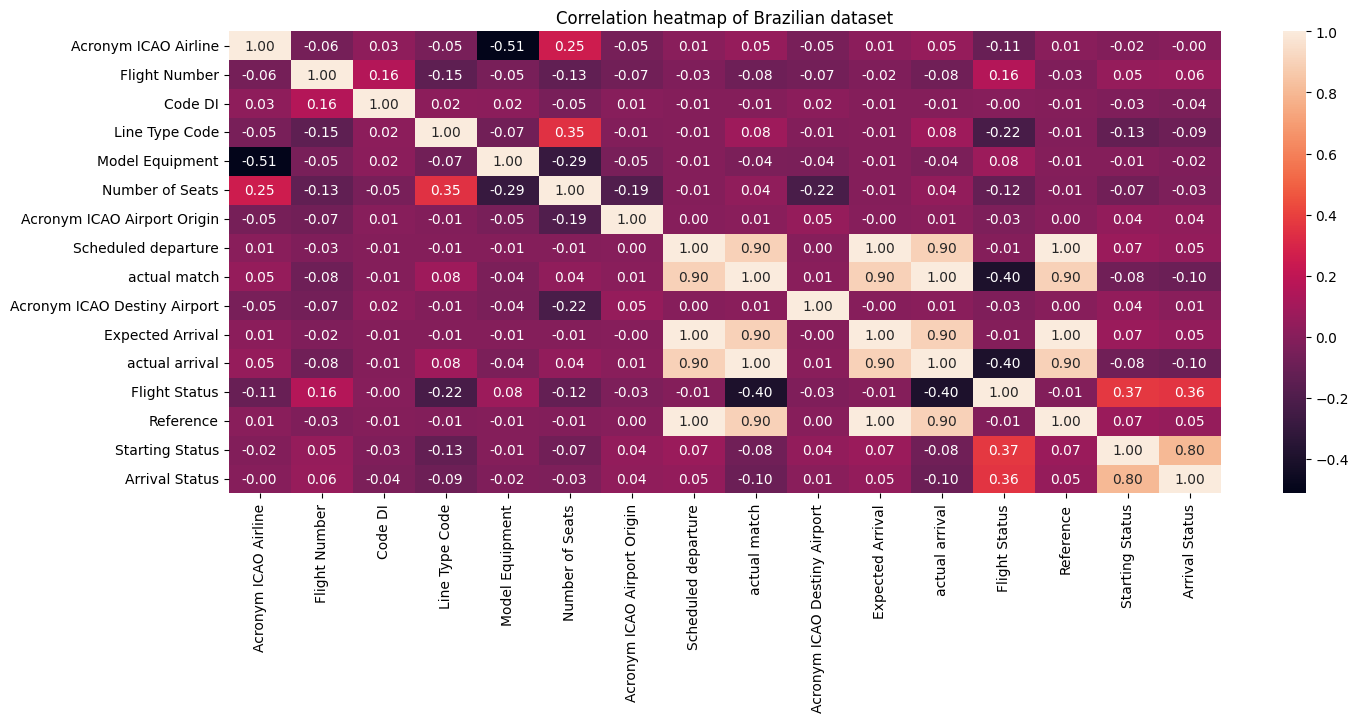

In [20]:
data_brazil3 = data_brazil2
for i, name in enumerate(data_brazil3.columns.values):
    if not is_numeric_dtype(data_brazil3[name]):
        data_brazil3[name] = data_brazil3[name].astype('category').cat.codes
plt.figure(figsize=(16, 6))
plt.title("Correlation heatmap of Brazilian dataset")
heatmap = sns.heatmap(data_brazil3.corr(), annot=True, fmt=".2f")
plt.show()




# # Drop Code DI column as it is highly zero-inflated
# data_brazil2.drop(columns=['Code DI'], inplace=True)